<h1>Forecasting Model Machine Learning</h1>

<p>@syahrulmwijaya</p>

<h2>Import all the module and data</h2>

<p>the module we're gonna use to forecast is the XGBoost since it is the most efficient module to perform some task like forecast out there</p>

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import optuna

import warnings
warnings.filterwarnings('ignore')

c:\Users\Syahrul Maulana W\.conda\envs\Data Science\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<p>Not only importing the data, I also rearrange the format od columns of all data used in here</p>

In [20]:
train_data = pd.read_csv("data sale/train.csv", parse_dates=['date'], index_col='date')
test_data = pd.read_csv("data sale/test.csv", parse_dates=['date'], index_col='date')

train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)

train_data.insert(0, "sales", train_data.pop("sales"), True)

train_data.head()

,sales,store_nbr,family,onpromotion
date,,,,
2013-01-01,0.0,1,AUTOMOTIVE,0
2013-01-01,0.0,1,BABY CARE,0
2013-01-01,0.0,1,BEAUTY,0
2013-01-01,0.0,1,BEVERAGES,0
2013-01-01,0.0,1,BOOKS,0


<h2>Time Series Cross Validation</h2>

<p>Time series cross validation is a technique used to evaluate the performance of time series forecasting models.</p>

In [22]:
#determine the rule of cross validatoin
tss = TimeSeriesSplit(n_splits=5, test_size=7128*30, gap=7128) #the test size has to be equal to how long we gonna forecast the data
#make sure data was arranged, otherwise the tss will gives error
df_tss = train_data.sort_index()

<p>In here i want to evaluate the data from 1 year past the from the last date of data</p>

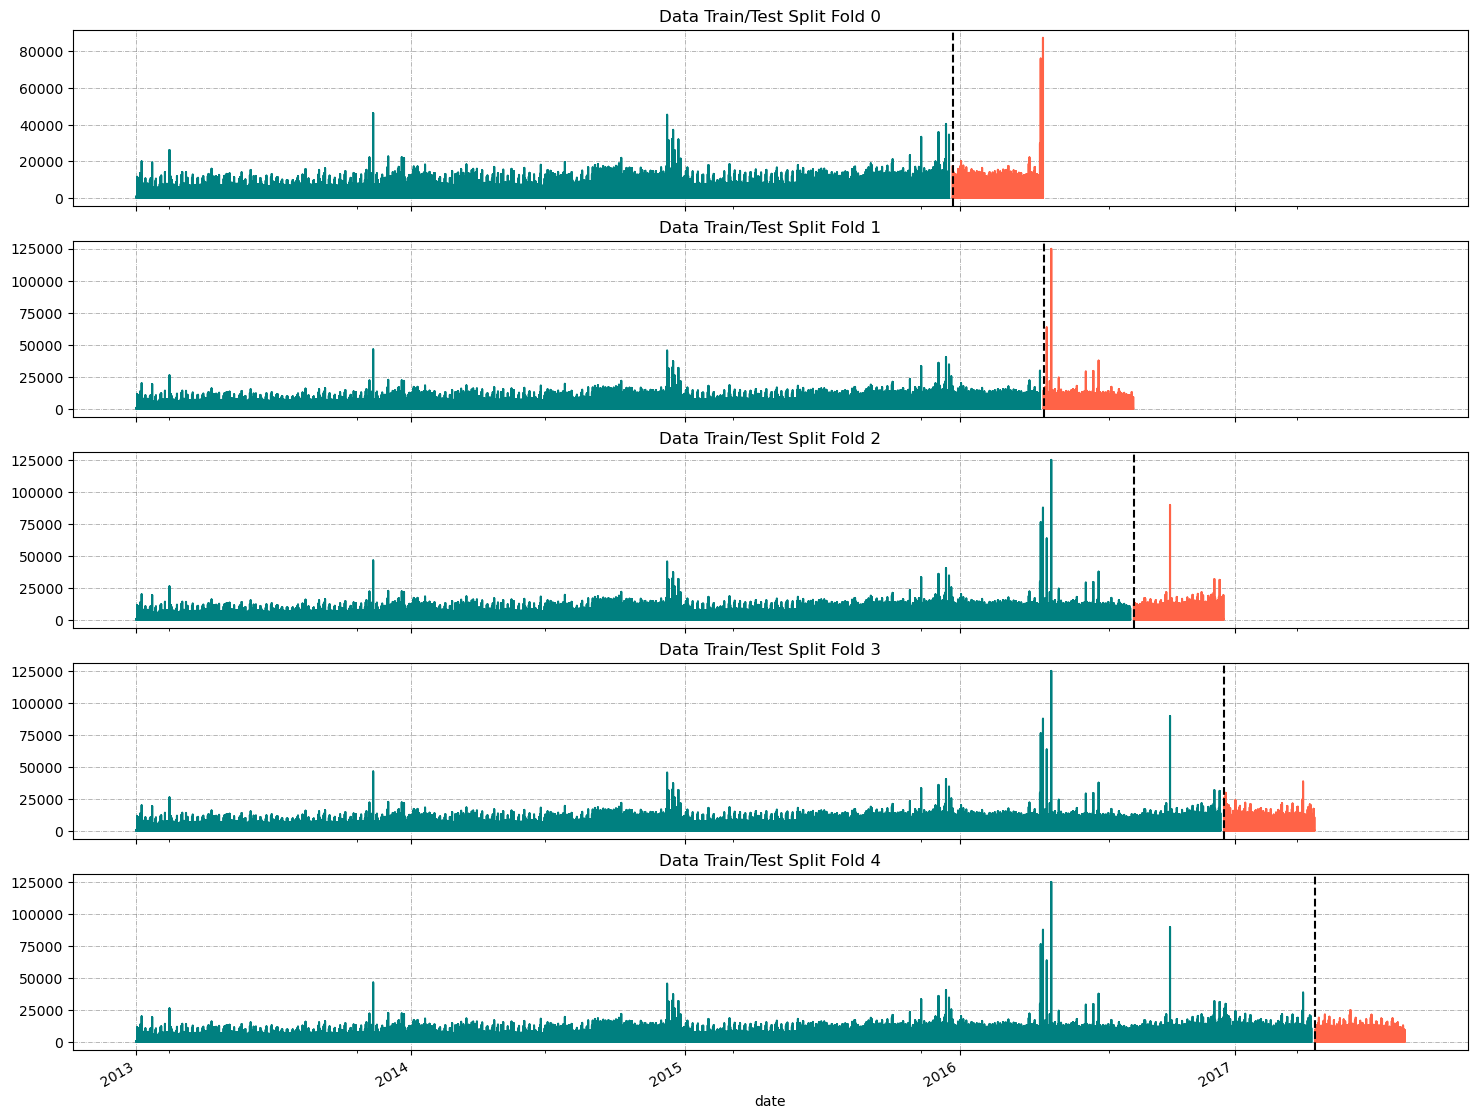

In [23]:
#make train and test data
train = []
test = []
fig, axs = plt.subplots(5, 1, figsize=(18, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(train_data):
    
    train = df_tss.iloc[train_idx]
    test = df_tss.iloc[val_idx]
    
    train['sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}', 
                          color='teal')
    
    test['sales'].plot(ax=axs[fold],
                         label='Test Set',
                         color='tomato')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    fold += 1
  
for ax in axs.flat:
    ax.grid(alpha=0.8, color='gray', linestyle='-.', linewidth=0.5)

plt.show()

<h2>Pre-Processing</h2>

<p>Now I have to preprocess the data to get the format that i want it to be processed including labeling all categorical data, giving more feature to get better forcast result and anything</p>

In [24]:

#make dictionary based on all value on all categorical data
def dictionary_maker(dataset):
    encoder = LabelEncoder()
    val_dict1 = []
    dictionary=[]
    a = 0
    for i in dataset.columns :
        if dataset[i].dtype.name == 'object':
            val_list = dataset[i].unique()
            val_coded = encoder.fit_transform(val_list)
            val_dict = pd.DataFrame({ 'label' : val_coded,
                                    i:val_list}).sort_values(by='label', ascending=True)
            if a > 0:
                dictionary = pd.merge(dictionary, val_dict, on='label', how='outer')
            if a == 0:
                dictionary = val_dict
            a+=1
            

    dictionary = dictionary.fillna('')        
    return dictionary


In [25]:
dictionary = dictionary_maker(train_data)
dictionary.head()

,label,family
0,0,AUTOMOTIVE
1,1,BABY CARE
2,2,BEAUTY
3,3,BEVERAGES
4,4,BOOKS


In [26]:
encoder = LabelEncoder()
encoder_family = encoder.fit(train_data['family'])
train_data['family'] = encoder_family.transform(train_data['family'])
test_data['family'] = encoder_family.transform(test_data['family'])
train_data.head()

,sales,store_nbr,family,onpromotion
date,,,,
2013-01-01,0.0,1,0,0
2013-01-01,0.0,1,1,0
2013-01-01,0.0,1,2,0
2013-01-01,0.0,1,3,0
2013-01-01,0.0,1,4,0


In [27]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.week
    return df

def add_lags(df):
    target_map = df[df.columns[0]].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [28]:
create_features(train_data)
add_lags(train_data)

train_data.head()

,sales,store_nbr,family,onpromotion,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,,,,
2013-01-01,0.0,1,0,0,0,1,1,1,2013,1,1,1,NaN,NaN,NaN
2013-01-01,0.0,1,1,0,0,1,1,1,2013,1,1,1,NaN,NaN,NaN
2013-01-01,0.0,1,2,0,0,1,1,1,2013,1,1,1,NaN,NaN,NaN
2013-01-01,0.0,1,3,0,0,1,1,1,2013,1,1,1,NaN,NaN,NaN
2013-01-01,0.0,1,4,0,0,1,1,1,2013,1,1,1,NaN,NaN,NaN


<h2>Define the Feature (input) and Target (output)</h2>

<p>Devide the data into 2 categories that will be used as input and output</p>

In [29]:
#define feature input nand the target
FEATURES = train_data.columns[1:train_data.columns.size]
TARGET = train_data.columns[0]

print(FEATURES)
print(TARGET)

Index(['store_nbr', 'family', 'onpromotion', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1',
       'lag2', 'lag3'],
      dtype='object')
sales


<h2>Overfitting Check</h2>

<p>Since I dont want the model to be poorly predict the future because it has the bias of the input, so I want to check the where the model become saturated and overfitted</p>

In [11]:
#determine the rule of cross validatoin
tss = TimeSeriesSplit(n_splits=5, test_size=7128*30, gap=7128) #the test size has to be equal to how long we gonna forecast the data
#make sure data was arranged, otherwise the tss will gives error
df_tss = train_data.sort_index()

In [12]:
#finding n_estimator so that the model will not overfit
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_tss):
        
    train = df_tss.iloc[train_idx]
    test = df_tss.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)
    train = add_lags(train)
    test = add_lags(test)  

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.3)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[06:46:03] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:869.30688	validation_1-rmse:1215.11975
[100]	validation_0-rmse:490.02328	validation_1-rmse:759.82751
[200]	validation_0-rmse:461.64069	validation_1-rmse:745.72870
[300]	validation_0-rmse:442.81284	validation_1-rmse:735.86737
[400]	validation_0-rmse:430.15665	validation_1-rmse:733.66827
[500]	validation_0-rmse:418.48908	validation_1-rms

<h2>Building the Final Model</h2>

<p>Then I build the model based on to do forecasting task, but before I go to handle the test data, I want to check how the model perform in the given hyperparameter, and tune it up to get the better model possible</p>

In [30]:
train_testing = train_data[train_data.index < '2017-01-01']
test_testing = train_data[train_data.index >= '2017-01-01']

X_train_testing = train_testing[FEATURES]
X_test_testing =  train_testing[TARGET]
model_xgb = xgb.XGBRegressor(base_score=0.5,
                             booster='gbtree',    
                             n_estimators=500,
                             objective='reg:squarederror',
                             num_parallel_tree = 3,
                             max_depth=5,
                             learning_rate=0.01)
model_xgb.fit(X_train_testing, X_test_testing,
        eval_set=[(X_train_testing, X_test_testing)],
        verbose=100)


[0]	validation_0-rmse:1101.22534
[100]	validation_0-rmse:727.18127
[200]	validation_0-rmse:625.31598
[300]	validation_0-rmse:577.13190
[400]	validation_0-rmse:538.34033
[499]	validation_0-rmse:516.99469


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=6,
             num_parallel_tree=3, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

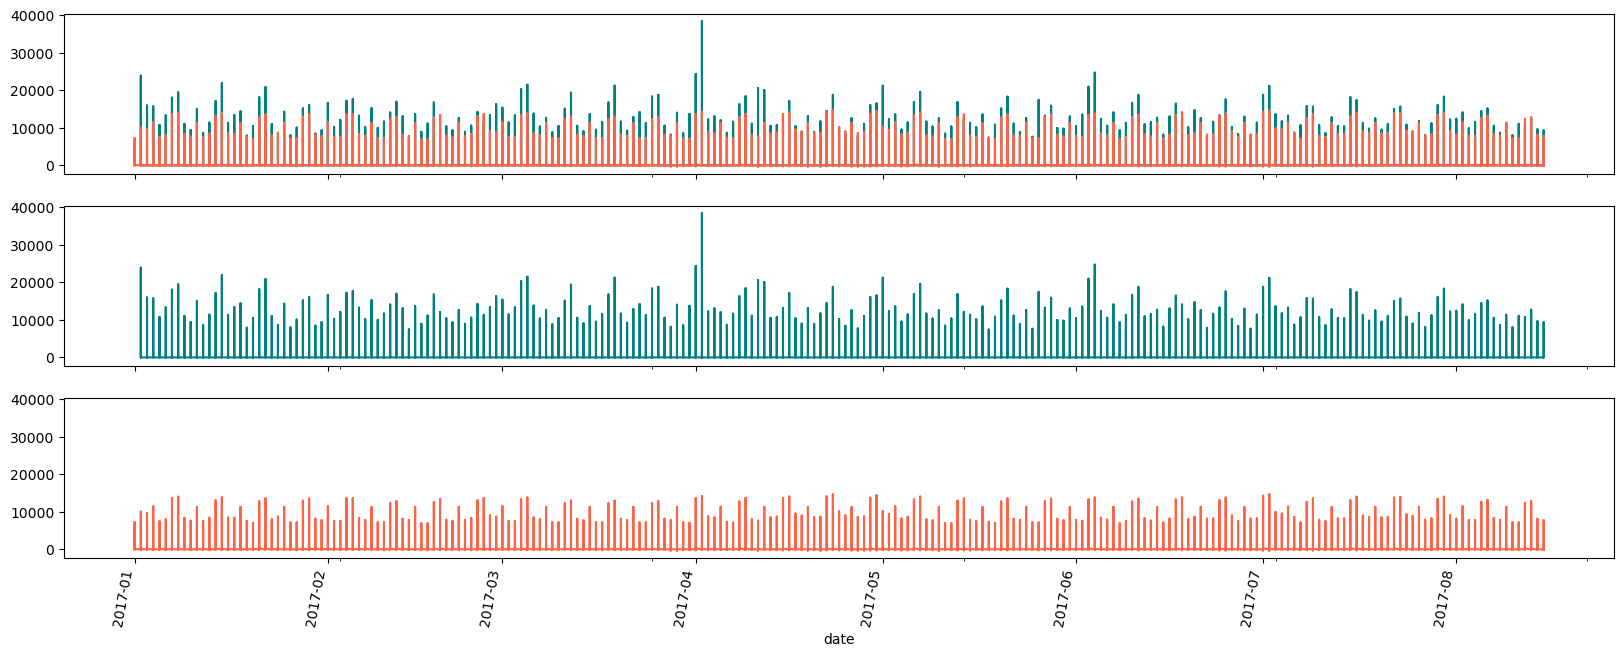

In [31]:
test_testing['prediction'] = model_xgb.predict(test_testing[FEATURES])

fig, ax = plt.subplots(3, 1, figsize=(20,8), sharey = True, sharex = True)

train_data[train_data.index > '2017-01-01']['sales'].plot(color='teal', ax=ax[0])
test_testing['prediction'].plot(color='tomato', ax=ax[0])

train_data[train_data.index > '2017-01-01']['sales'].plot(color='teal', ax=ax[1])

test_testing['prediction'].plot(color='tomato', ax=ax[2])

plt.xticks(rotation = 80);


<p>After getting the best model possible that potrayed in subtest above, I start preprocessing the test data so it has all the feature provided in the training data</p>

In [32]:
train_data['IsFuture'] = False
test_data['IsFuture'] = True

data_all = pd.concat([train_data, test_data])

create_features(data_all)
add_lags(data_all)

predict = data_all.query('IsFuture')

predict.head()

,sales,store_nbr,family,onpromotion,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,IsFuture
date,,,,,,,,,,,,,,,,
2017-08-16,NaN,1,0,0,0,2,3,8,2017,228,16,33,14.934,17.124,15.106,True
2017-08-16,NaN,1,1,0,0,2,3,8,2017,228,16,33,14.934,17.124,15.106,True
2017-08-16,NaN,1,2,2,0,2,3,8,2017,228,16,33,14.934,17.124,15.106,True
2017-08-16,NaN,1,3,20,0,2,3,8,2017,228,16,33,14.934,17.124,15.106,True
2017-08-16,NaN,1,4,0,0,2,3,8,2017,228,16,33,14.934,17.124,15.106,True


<p>Last part of building a model is retrain the model with all given training data</p>

In [33]:
X_all = train_data[FEATURES]
y_all = train_data[TARGET]

model_xgb.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:1152.03503
[100]	validation_0-rmse:767.97101
[200]	validation_0-rmse:645.54004
[300]	validation_0-rmse:587.96954
[400]	validation_0-rmse:553.51611
[499]	validation_0-rmse:531.38055


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=6,
             num_parallel_tree=3, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<h2>Forecasting Session</h2>

<p>And the purpose of this notebook, forecasting, same as what I did before, I just have to feed the fixed model with the input features from the test data to predict the target. </p>

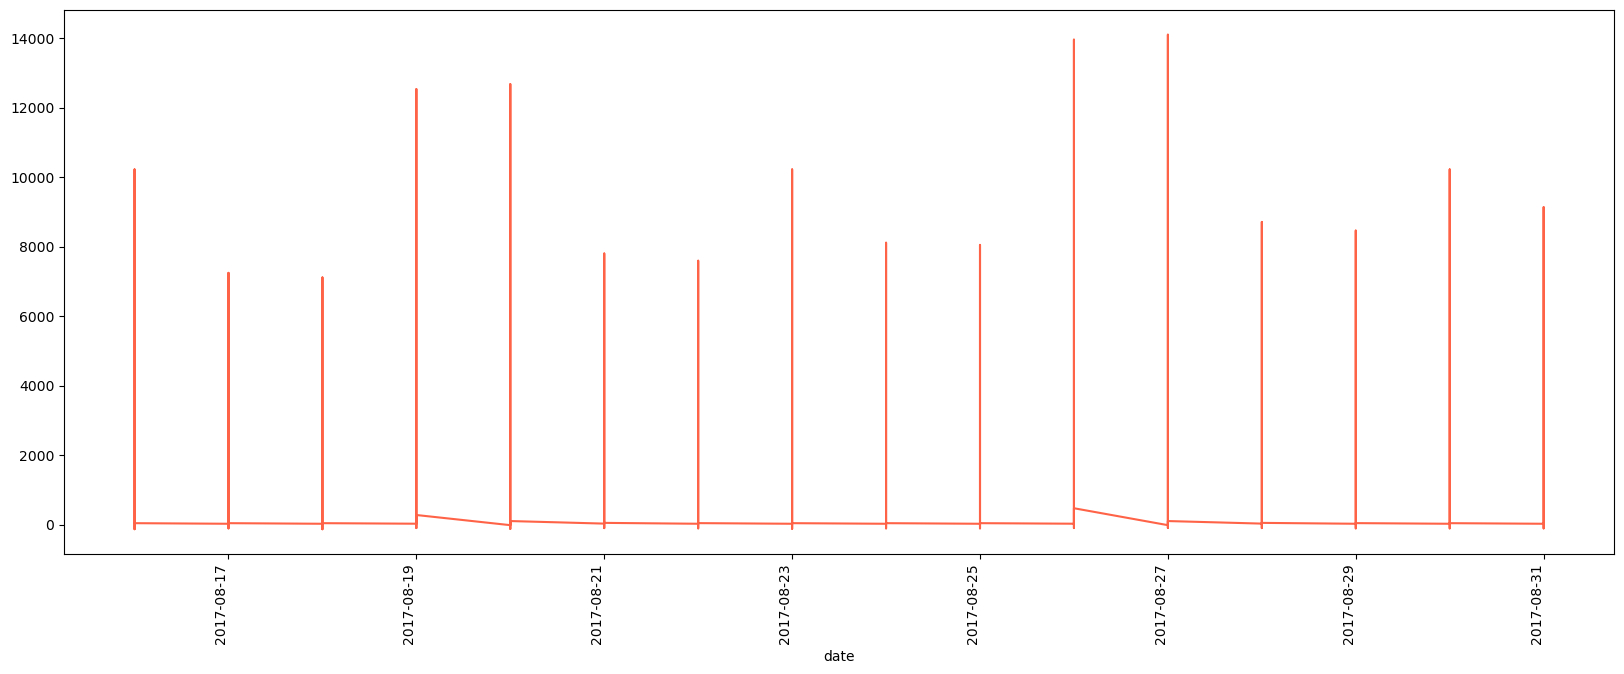

In [34]:
predict['sales'] = model_xgb.predict(predict[FEATURES])

plt.subplots(figsize=(20,8))
predict['sales'].plot(color='tomato')
plt.xticks(rotation=90);

<p>From the picture above, we can see that the number of sales are kinda fluctuative, and the sale comes to peak around 2017-08-26 and 2018-08-27</p>

<h2>Feature Importance</h2>

<p>Last but not least, we can see which feature that gives the most influance to the fluctuation of the target, in term of this data is the sales number</p>

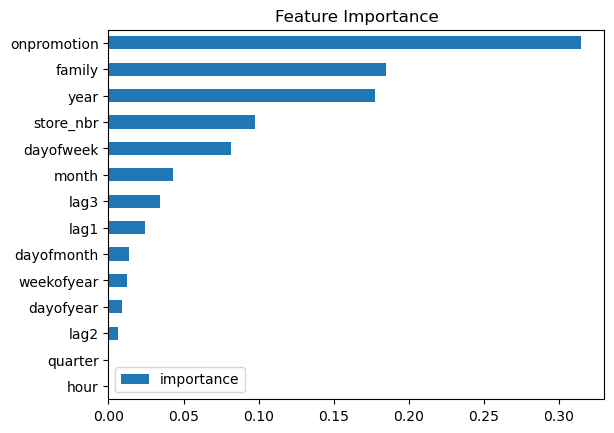

In [35]:
importance = pd.DataFrame(data = model_xgb.feature_importances_,
                          index = model_xgb.get_booster().feature_names,
                          columns=['importance'])
importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<p>From the image above I can see that promotion gives the most impact of the number of sales, and in term of business, the family (type of goods) and store also determine wether the sales will be high or low</p>

<p>#########################################################################</p>
<p></p>

<p>we can actually find the perfect value for each parameter in XGBRegressor function to build the most optimal model as possible, but since we have such a big data, it will takes a long time to do, so I'll just leave it here as a note.</p>

<p>#######################################################################</p>
<p>
def xgb_objective(trial):</p>
<p>
    n_estimators = trial.suggest_int('n_estimators', 100, 1000),
    model = xgb.XGBRegressor(n_estimators=n_estimators),
    model.fit(X_train_testing, X_test_testing),
    y_pred = model.predict(test_testing[FEATURES]),
    return mean_squared_error(test_testing[TARGET], y_pred)

study = optuna.create_study()
study.optimize(xgb_objective, n_trials=100)

best_n_estimators = study.best_params
</p>
<p>
######################################################################</p>